In [ ]:
from tensorflow.keras import backend as K
K.clear_session()
!pip install rarfile
import os
import pandas as pd
import gdown
import rarfile
import shutil
from PIL import Image

#
#https://drive.google.com/file/d/1ATotTLVBrB3tNlj4NRcV4WzqR24UUkJ3/view?usp=drive_link
#https://drive.google.com/file/d/1OGuEqyNj4aSPSW16wavw13jmp5PXS_b3/view?usp=sharing
url = 'https://drive.google.com/uc?id=1ATotTLVBrB3tNlj4NRcV4WzqR24UUkJ3'
output_rar = '/content/SDR.rar'
gdown.download(url, output_rar, quiet=False)
# Extract the RAR file
with rarfile.RarFile(output_rar, 'r') as rar_ref:
    rar_ref.extractall('/content')
# Path to the extracted dataset folder
dataset_folder = '/content/SDR'

Downloading...
From (original): https://drive.google.com/uc?id=1ATotTLVBrB3tNlj4NRcV4WzqR24UUkJ3
From (redirected): https://drive.google.com/uc?id=1ATotTLVBrB3tNlj4NRcV4WzqR24UUkJ3&confirm=t&uuid=3f733ff7-3bf2-4279-8bf0-ebbb3bdf861b
To: /content/SDR.rar
100%|██████████| 231M/231M [00:04<00:00, 46.5MB/s]


Found 3340 images belonging to 2 classes.
Found 836 images belonging to 2 classes.
94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
51877672/51877672 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


418/418 ━━━━━━━━━━━━━━━━━━━━ 703s 864ms/step - accuracy: 0.8248 - loss: 5.6539 - val_accuracy: 0.9713 - val_loss: 3.3662 - learning_rate: 1.0000e-04
Epoch 2/50
418/418 ━━━━━━━━━━━━━━━━━━━━ 138s 254ms/step - accuracy: 0.9209 - loss: 3.1822 - val_accuracy: 0.9653 - val_loss: 2.2908 - learning_rate: 1.0000e-04
Epoch 3/50
418/418 ━━━━━━━━━━━━━━━━━━━━ 102s 242ms/step - accuracy: 0.9312 - loss: 2.1951 - val_accuracy: 0.9689 - val_loss: 1.5917 - learning_rate: 1.0000e-04
Epoch 4/50
418/418 ━━━━━━━━━━━━━━━━━━━━ 103s 243ms/step - accuracy: 0.9438 - loss: 1.5424 - val_accuracy: 0.9665 - val_loss: 1.1445 - learning_rate: 1.0000e-04
Epoch 5/50
418/418 ━━━━━━━━━━━━━━━━━━━━ 146s 254ms/step - accuracy: 0.9620 - loss: 1.0827 - val_accuracy: 0.9641 - val_loss: 0.8567 - learning_rate: 1.0000e-04
Epoch 6/50
418/418 ━━━━━━━━━━━━━━━━━━━━ 107s 251ms/step - accuracy: 0.9574 - loss: 0.8070 - val_accuracy: 0.9593 - val_loss: 0.6316 - learning_rate: 1.0000e-04
Epoch 7/50
418/418 ━━━━━━━━━━━━━━━━━━━━ 103s 244ms/

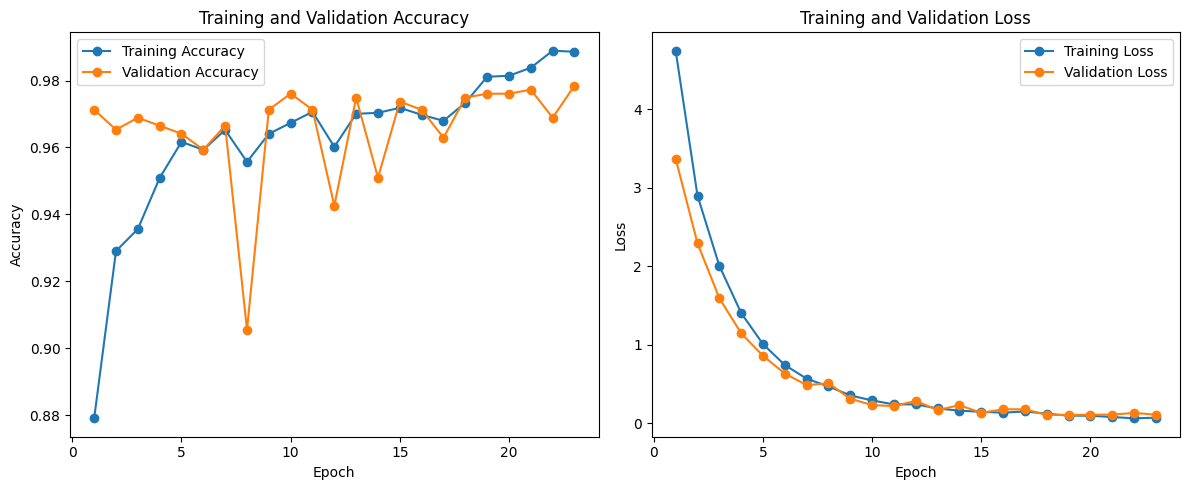

Saved model weights to /content/SDS/final_model_weights.weights.h5
105/105 ━━━━━━━━━━━━━━━━━━━━ 37s 192ms/step

Classification Report:
               precision    recall  f1-score   support

          DR       0.98      0.97      0.98       441
         NDR       0.97      0.98      0.97       395

    accuracy                           0.97       836
   macro avg       0.97      0.98      0.97       836
weighted avg       0.97      0.97      0.97       836



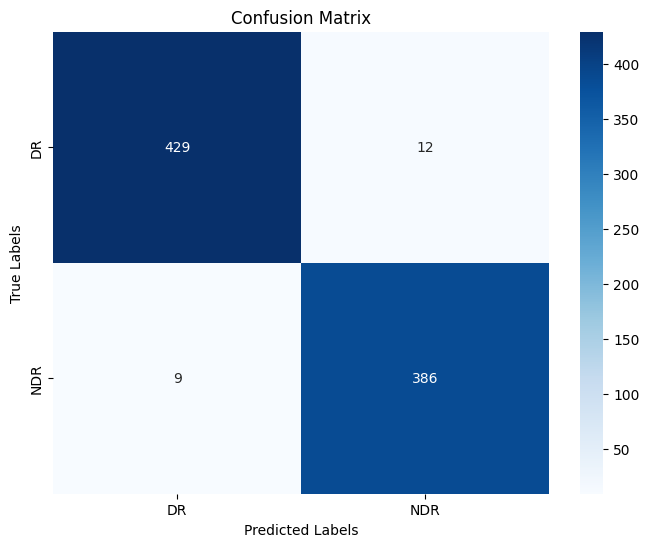

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import ResNet50V2, DenseNet169
from tensorflow.keras.layers import Input, Concatenate, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# ================================
# 1. Set Random Seeds for Reproducibility
# ================================
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

# ================================
# 2. Define Constants and Paths
# ================================
INPUT_SHAPE = (224, 224, 3)
BATCH_SIZE = 8  # Smaller batch size for better generalization
NUM_CLASSES = 2  # Change based on your dataset's number of classes
EPOCHS = 50
INITIAL_LR = 1e-4  # Reduced initial learning rate to avoid large initial loss

# Use the paths from the previous code
TRAIN_DIR = '/content/SDS/Train'  # Training data directory
VALID_DIR = '/content/SDS/Test'  # Validation data directory
DRIVE_MODEL_PATH = '/content/SDS'

# Ensure the directory exists for saving outputs
os.makedirs(DRIVE_MODEL_PATH, exist_ok=True)

# ================================
# 3. Create Data Generators with Augmentation
# ================================
datagen_train = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen_val = ImageDataGenerator(rescale=1./255)

train_generator = datagen_train.flow_from_directory(
    TRAIN_DIR,
    target_size=INPUT_SHAPE[:2],
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=SEED
)

valid_generator = datagen_val.flow_from_directory(
    VALID_DIR,
    target_size=INPUT_SHAPE[:2],
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# ================================
# 4. Build a Simplified Multi-Branch Model with Moderate Regularization
# ================================

def build_model():
    inputs = Input(shape=INPUT_SHAPE, name="main_input")

    # Instantiate only two base models to reduce complexity
    resnet_base = ResNet50V2(weights='imagenet', include_top=False, pooling='avg', name='resnet_base')
    densenet_base = DenseNet169(weights='imagenet', include_top=False, pooling='avg', name='densenet_base')

    # Pass the input through each model independently
    resnet_out = resnet_base(inputs)
    densenet_out = densenet_base(inputs)

    # Concatenate the outputs of the models
    combined = Concatenate(name='concatenate')([resnet_out, densenet_out])

    # Add fully connected layers with reduced L2 regularization and dropout
    x = Dense(256, activation='relu', kernel_regularizer=l2(0.01), name='fc1')(combined)
    x = Dropout(0.5, name='dropout1')(x)  # Moderate dropout rate
    x = Dense(128, activation='relu', kernel_regularizer=l2(0.01), name='fc2')(x)
    x = Dropout(0.5, name='dropout2')(x)

    output = Dense(NUM_CLASSES, activation='softmax', name='output')(x)

    # Define inputs and outputs in the final model
    model = Model(inputs=inputs, outputs=output, name='RegularizedMultiBranchModel')
    return model

# Build and compile the model
model = build_model()
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=INITIAL_LR),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# ================================
# 5. Training with Early Stopping and Learning Rate Reduction
# ================================
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# Learning rate reduction on plateau
lr_reduction = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-6,
    verbose=1
)

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=valid_generator,
    callbacks=[early_stopping, lr_reduction],
    verbose=1
)

# ================================
# Plot Training and Validation Accuracy and Loss
# ================================

def plot_training_history(history):
    epochs = range(1, len(history.history['accuracy']) + 1)
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(12, 5))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_acc, label="Training Accuracy", marker='o')
    plt.plot(epochs, val_acc, label="Validation Accuracy", marker='o')
    plt.title("Training and Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_loss, label="Training Loss", marker='o')
    plt.plot(epochs, val_loss, label="Validation Loss", marker='o')
    plt.title("Training and Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot the training history
plot_training_history(history)

# ================================
# Save the Model Weights
# ================================
model.save_weights(os.path.join(DRIVE_MODEL_PATH, 'final_model_weights.weights.h5'))
print(f'Saved model weights to {os.path.join(DRIVE_MODEL_PATH, "final_model_weights.weights.h5")}')

# ================================
# 6. Model Evaluation on Validation Set
# ================================
# Get predictions on the validation set
valid_generator.reset()  # Reset the validation generator for proper predictions
predictions = model.predict(valid_generator, verbose=1)

# Convert predictions to class labels
predicted_classes = np.argmax(predictions, axis=1)

# Get true class labels
true_classes = valid_generator.classes

# Calculate classification report (precision, recall, F1-score)
report = classification_report(true_classes, predicted_classes, target_names=train_generator.class_indices)
print("\nClassification Report:\n", report)

# Confusion Matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=train_generator.class_indices.keys(), yticklabels=train_generator.class_indices.keys())
plt.title('Confusion Matrix')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()
